In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
import gzip
import os
import pickle
import platform

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.misc import imread

from common import * 
import preprocess
import model_io

In [33]:
DATA_DIR = 'data/ccw_1'

log = preprocess.load_driving_log(os.path.join(DATA_DIR, DRIVING_LOG_CSV))
log = preprocess.smooth_control_inputs(log, 1)
print(log.head())

                                        center_image  \
0  data/ccw_1/IMG/center_2016_12_08_21_38_10_346.jpg   
1  data/ccw_1/IMG/center_2016_12_08_21_38_10_462.jpg   
2  data/ccw_1/IMG/center_2016_12_08_21_38_10_578.jpg   
3  data/ccw_1/IMG/center_2016_12_08_21_38_10_678.jpg   
4  data/ccw_1/IMG/center_2016_12_08_21_38_10_779.jpg   

                                        left_image  \
0  data/ccw_1/IMG/left_2016_12_08_21_38_10_346.jpg   
1  data/ccw_1/IMG/left_2016_12_08_21_38_10_462.jpg   
2  data/ccw_1/IMG/left_2016_12_08_21_38_10_578.jpg   
3  data/ccw_1/IMG/left_2016_12_08_21_38_10_678.jpg   
4  data/ccw_1/IMG/left_2016_12_08_21_38_10_779.jpg   

                                        right_image  steering_angle  throttle  \
0  data/ccw_1/IMG/right_2016_12_08_21_38_10_346.jpg             0.0       0.0   
1  data/ccw_1/IMG/right_2016_12_08_21_38_10_462.jpg             0.0       0.0   
2  data/ccw_1/IMG/right_2016_12_08_21_38_10_578.jpg             0.0       0.0   
3  data/ccw_1/

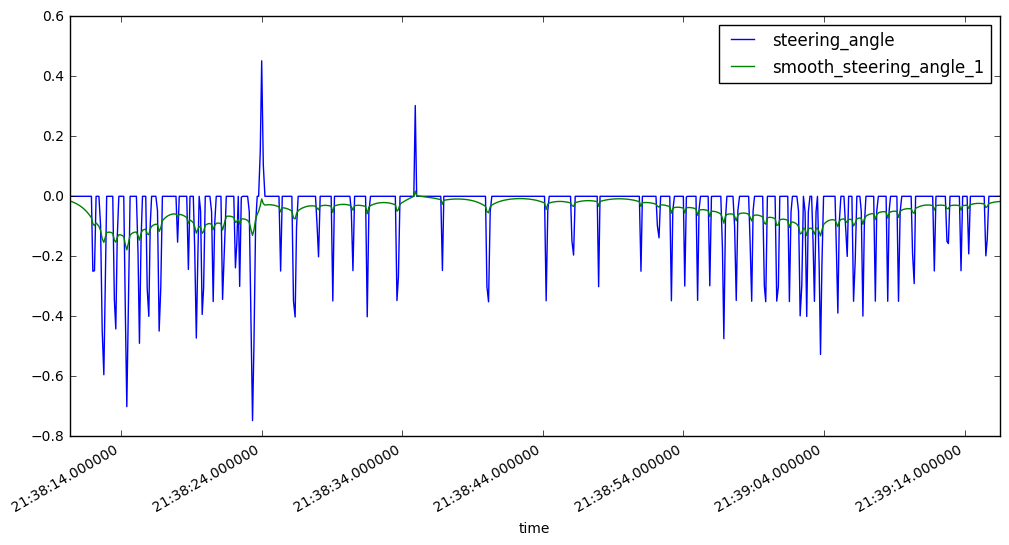

In [34]:
def plot_smooth_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_smooth_steering_angle()

In [35]:
log.to_pickle(os.path.join(DATA_DIR, DRIVING_LOG_PICKLE))

In [19]:
import math
import cv2

def steering_angle_to_radians(steering_angle):
    """
    The recorded steering angle ranges from -1 to 1.
    In the sim, it gives values from -20 degrees to 20 degrees.
    """
    return math.radians(steering_angle * 20.0)

def draw_steering_angle(image, steering_angle, color, thickness=2):
    bottom_x = image.shape[1] / 2.0
    bottom_y = image.shape[0]
    radius = bottom_y / 2.0
    steering_angle_radians = steering_angle_to_radians(steering_angle)
    top_x = bottom_x + radius * math.sin(steering_angle_radians)
    top_y = bottom_y - radius * math.cos(steering_angle_radians)
    bottom_x, bottom_y = int(round(bottom_x)), int(round(bottom_y))
    top_x, top_y = int(round(top_x)), int(round(top_y))
    cv2.line(image, (bottom_x, bottom_y), (top_x, top_y), color, thickness)

def make_steering_movie(
    filestem,
    log,
    smoothed_steering_angle_column,
    predicted_steering_angle_column=None):
    
    if platform.system() == 'Linux':
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        filename = filestem + '.avi'
    else:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')        
        filename = filestemp + '.mp4'
        
    input_color = [0, 0, 255]
    smoothed_color = [0, 255, 0]
    predicted_color = [255, 0, 0]
    video = cv2.VideoWriter(filename, fourcc, 10, IMAGE_SHAPE[0:2][::-1])
    for i in range(len(log)):
        if i % 50 == 0:
            print('frame', i)
        image = imread(log['center_image'].values[i])
        steering_angle = log['steering_angle'].values[i]
        draw_steering_angle(image, steering_angle, input_color)

        smoothed_steering_angle = log[smoothed_steering_angle_column].values[i]
        draw_steering_angle(image, smoothed_steering_angle, smoothed_color)
        
        if predicted_steering_angle_column is not None:
            predicted_steering_angle = log[predicted_steering_angle_column].values[i]
            draw_steering_angle(image, predicted_steering_angle, predicted_color)
            
        video.write(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    video.release()
make_steering_movie('test', log[0:200], 'smooth_steering_angle_1')

frame 0
frame 50
frame 100
frame 150


# Base Model

The full inception model is too slow for my laptop, so I am just using the first few layers.

Loading the whole inception model is very slow, so we also cut out only the weights we need and save them for loading later.

In [6]:
import inception
import model_io

model_io.save_model(
    BASE_MODEL_JSON_FILE,
    BASE_MODEL_WEIGHTS_FILE,
    inception.make_cut_model())

Using TensorFlow backend.


In [10]:
model_io.load_base_model().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 79, 159, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 79, 159, 32)   64          convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 77, 157, 32)   9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

# Bottleneck

Training is hopelessly slow if we don't botteneck the features.

In [20]:
import bottleneck_features

In [36]:
bottleneck_features.run(log, DATA_DIR)

index 0
index 50
index 100
index 150
index 200
index 250
index 300
index 350
index 400
index 450
index 500
index 550
index 600
index 650
index 700
index 750
index 800
index 850
index 900
index 950
index 1000
index 1050
index 1100
index 1150
index 1200
index 1250


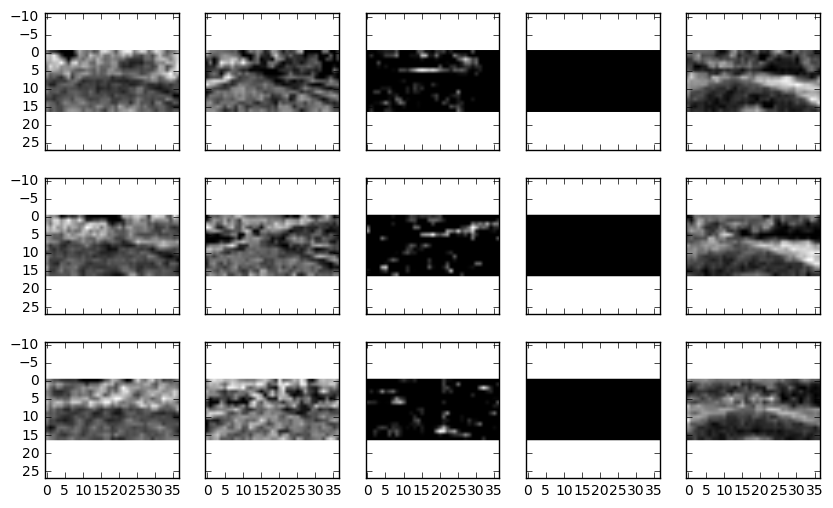

In [37]:
def plot_bottleneck_output(num_images, num_channels, image_stride=50):
    fig, axes = plt.subplots(num_images, num_channels,
                             figsize=(2*num_channels, 2*num_images),
                             sharex=True, sharey=True)
    for i in range(num_images):
        for j in range(num_channels):
            index = i * image_stride
            image = np.load(get_bottleneck_pathname(DATA_DIR, index))['center_image']
            axes[i][j].imshow(image[:,:,j], cmap='gray')
plot_bottleneck_output(3,5)

In [ ]:
# from keras.applications.inception_v3 import preprocess_input
# from scipy.misc import imread
# import model
# from datetime import datetime
# base_model = model.make_base_model()
# base_model.summary()
# def test_convert():
#     """
#     See how long it takes to run a prediction.
#     """
#     image = imread('data/clean_1/IMG/center_2016_12_04_21_19_10_094.jpg')
#     plt.imshow(image)

#     print(datetime.now(), 'preprocess')
#     X = preprocess_input(image.astype('float32'))
#     print(datetime.now(), 'predict')
#     base_X = base_model.predict(np.array([X]))
#     print(datetime.now(), base_X.shape)
#     base_X = np.reshape(base_X, (17, 37, 256))
#     plt.imshow(base_X[:,:,1], cmap='gray')
# test_convert()

# Model

In [25]:
import model

In [53]:
result_model = model.build(
    input_shape=np.load(get_bottleneck_pathname(DATA_DIR, 0))['center_image'].shape
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 17, 37, 64)    16448       convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 40256)         0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 1)             40257       flatten_5[0][0]                  
Total params: 56705
____________________________________________________________________________________________________


In [54]:
model.train(result_model, DATA_DIR, log, nb_epoch=20)

Epoch 1/20
1027/1027 [==============================] - 3s - loss: 0.4502 - val_loss: 0.2590
Epoch 2/20
1027/1027 [==============================] - 2s - loss: 0.1013 - val_loss: 0.0709
Epoch 3/20
1027/1027 [==============================] - 2s - loss: 0.0735 - val_loss: 0.0527
Epoch 4/20
1027/1027 [==============================] - 2s - loss: 0.0770 - val_loss: 0.0612
Epoch 5/20
1027/1027 [==============================] - 2s - loss: 0.0955 - val_loss: 0.0893
Epoch 6/20
1027/1027 [==============================] - 2s - loss: 0.1272 - val_loss: 0.2134


In [44]:
model_io.save_model('model.json', 'model.h5', result_model)

In [26]:
base_model = model_io.load_base_model()

2016-12-07 23:30:18.866664 preprocess
2016-12-07 23:30:18.867468 base predict
2016-12-07 23:30:19.066349 predict
2016-12-07 23:30:19.631505 result 0.07920446991920471


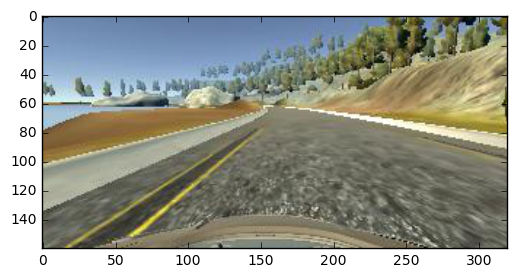

In [47]:
result_model = model_io.load_model('model.json', 'model.h5')

In [45]:
log['predicted_steering_angle'] = result_model.predict_generator(
    model.generate_data(DATA_DIR, log, np.arange(len(log))),
    val_samples=len(log)
).flatten()

In [41]:
make_steering_movie('test', log[0:500], 'smooth_steering_angle_1', 'predicted_steering_angle')

frame 0
frame 50
frame 100
frame 150
frame 200
frame 250
frame 300
frame 350
frame 400
frame 450


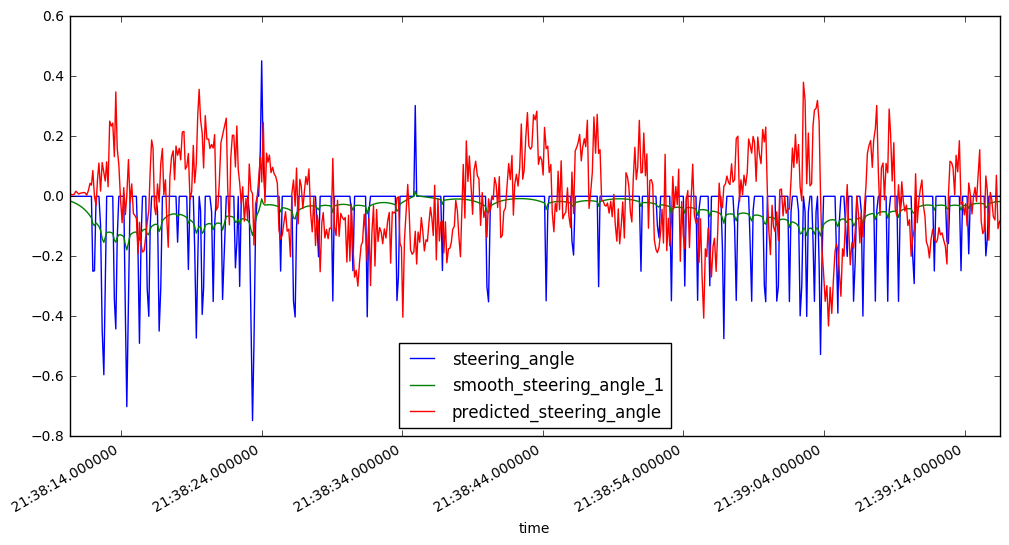

In [55]:
def plot_predicted_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1', 'predicted_steering_angle']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_predicted_steering_angle()

NameError: name 'bottleneck_center_image' is not defined